In [75]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from pandas import Timedelta
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

%matplotlib inline

In [2]:
# !pwd

### Data Description

Telemetry Time Series Data (PdM_telemetry.csv): It consists of hourly average of voltage, rotation, pressure, vibration collected from 100 machines for the year 2015.

Error (PdM_errors.csv): These are errors encountered by the machines while in operating condition. Since, these errors don't shut down the machines, these are not considered as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.

Maintenance (PdM_maint.csv): If a component of a machine is replaced, that is captured as a record in this table. Components are replaced under two situations: 1. During the regular scheduled visit, the technician replaced it (Proactive Maintenance) 2. A component breaks down and then the technician does an unscheduled maintenance to replace the component (Reactive Maintenance). This is considered as a failure and corresponding data is captured under Failures. Maintenance data has both 2014 and 2015 records. This data is rounded to the closest hour since the telemetry data is collected at an hourly rate.

Failures (PdM_failures.csv): Each record represents replacement of a component due to failure. This data is a subset of Maintenance data. This data is rounded to the closest hour since the telemetry data is collected at an hourly rate.

Metadata of Machines (PdM_Machines.csv): Model type & age of the Machines.

In [3]:
telemetry_raw = pd.read_csv("Data/PdM_telemetry.csv")
errors_raw = pd.read_csv("Data/PdM_errors.csv")
maintenance_raw = pd.read_csv("Data/PdM_maint.csv")
failures_raw = pd.read_csv("Data/PdM_failures.csv")
metadata_raw = pd.read_csv("Data/PdM_machines.csv")

datasets = {"telemetry": telemetry_raw, "errors": errors_raw, "maintenance": maintenance_raw, "failures": failures_raw, "metadata": metadata_raw}

### Exploratory Data Analysis

In [4]:
for k,v in datasets.items():
    print(f"Size of {k} dataset:", v.shape)

Size of telemetry dataset: (876100, 6)
Size of errors dataset: (3919, 3)
Size of maintenance dataset: (3286, 3)
Size of failures dataset: (761, 3)
Size of metadata dataset: (100, 3)


In [5]:
telemetry_raw.head(2)

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973


In [6]:
metadata_raw.head(2)

,machineID,model,age
0,1,model3,18
1,2,model4,7


In [7]:
# Makes sense to add machine metadata alongside machine telemetry to act as predictors

feature_df = pd.merge(telemetry_raw, metadata_raw, on="machineID", how = "outer")
assert feature_df.shape[0] == telemetry_raw.shape[0]
feature_df.head(2)

,datetime,machineID,volt,rotate,pressure,vibration,model,age
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,model3,18


In [8]:
print(f"The first and last datetime for telemetry observations are {feature_df['datetime'].sort_values().min()} and {feature_df['datetime'].sort_values().max()} respectively")
print(f"The first and last datetime for error observations are {errors_raw['datetime'].sort_values().min()} and {errors_raw['datetime'].sort_values().max()} respectively")
print(f"The first and last datetime for failure observations are {failures_raw['datetime'].sort_values().min()} and {failures_raw['datetime'].sort_values().max()} respectively")
print(f"The first and last datetime for maintenance observations are {maintenance_raw['datetime'].sort_values().min()} and {maintenance_raw['datetime'].sort_values().max()} respectively")

The first and last datetime for telemetry observations are 2015-01-01 06:00:00 and 2016-01-01 06:00:00 respectively
The first and last datetime for error observations are 2015-01-01 06:00:00 and 2016-01-01 05:00:00 respectively
The first and last datetime for failure observations are 2015-01-02 03:00:00 and 2015-12-31 06:00:00 respectively
The first and last datetime for maintenance observations are 2014-06-01 06:00:00 and 2016-01-01 06:00:00 respectively


In [9]:
errors_raw.head(2) # 3919

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3


In [10]:
failures_raw.head(2) # 761

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1


In [11]:
failures_raw['time'] = failures_raw['datetime'].apply(lambda x: x.split(" ")[1])
failures_raw["time"].unique()

# All failures are recorded either at 0600 hrs or 0300 hrs

array(['06:00:00', '03:00:00'], dtype=object)

In [12]:
maintenance_raw.head(2) # 3286

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4


In [13]:
maintenance_raw['time'] = maintenance_raw['datetime'].apply(lambda x: x.split(" ")[1])
maintenance_raw["time"].unique()

# Most maintenance happens around 0600 hrs

array(['06:00:00'], dtype=object)

In [14]:
is_subset = failures_raw.isin(maintenance_raw).all().all()
print(is_subset)

# confirming if any failures are present in maintenance dataset at all or no

False


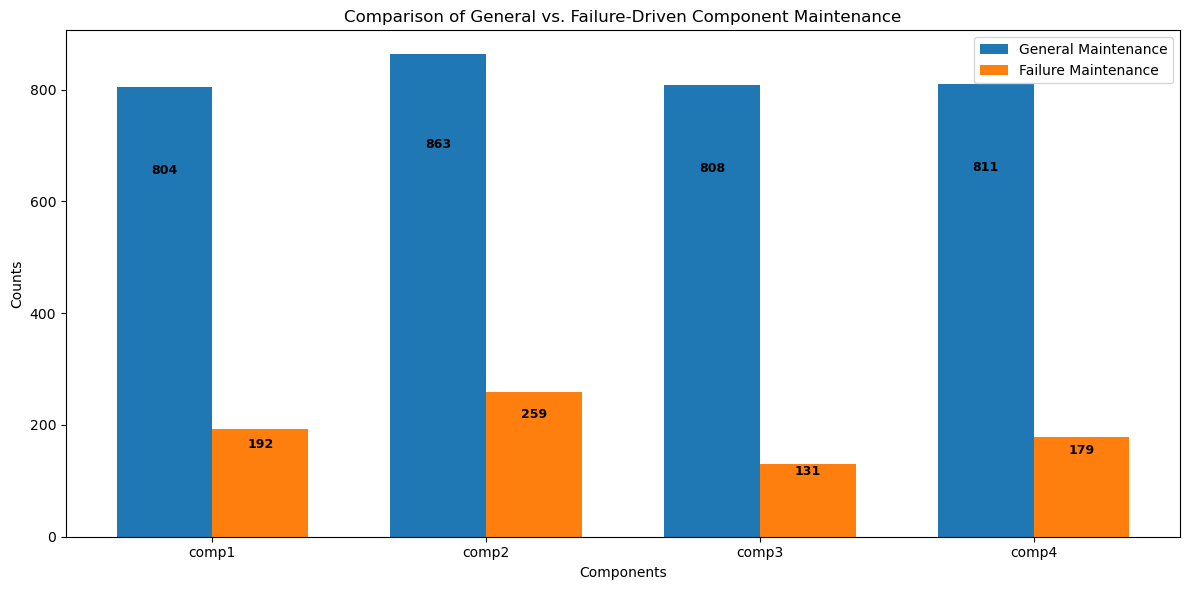

In [15]:
# Is a certain component more fragile/susceptible to maintenance? 

failure_dict = failures_raw['failure'].value_counts().to_dict()
maint_dict = maintenance_raw['comp'].value_counts().to_dict()

components = list(failure_dict.keys())
components.sort()
failure_counts = [failure_dict.get(comp) for comp in components]
maint_counts = [maint_dict.get(comp) for comp in components]

# Set positions for bars
x = np.arange(len(components))
width = 0.35  # width of the bars

# Plot bars side-by-side
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, maint_counts, width, label='General Maintenance')
bars2 = ax.bar(x + width/2, failure_counts, width, label='Failure Maintenance')

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width()/2, 0.8*height),
                xytext=(0, 0),
                textcoords='offset points',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Labeling and titles
ax.set_xlabel('Components')
ax.set_ylabel('Counts')
ax.set_title('Comparison of General vs. Failure-Driven Component Maintenance')
ax.set_xticks(x)
ax.set_xticklabels(components)
ax.legend()

plt.tight_layout()
plt.show()

Most components are maintained at the same frequency in general. Interestingly, component 2 is the most replaced followed closely by component 1 when a failure occurs.

<BarContainer object of 5 artists>

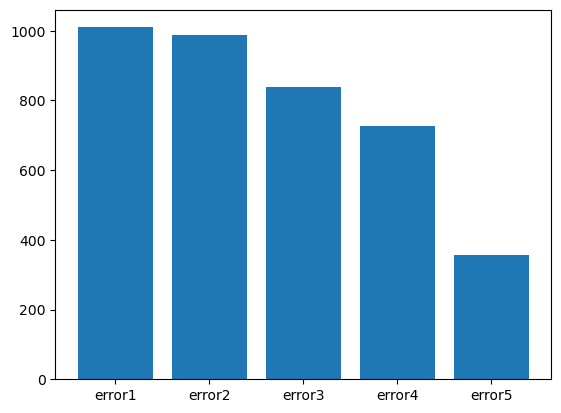

In [16]:
error_dict = errors_raw['errorID'].value_counts().to_dict()
plt.bar(error_dict.keys(),error_dict.values())

In [17]:
failure_error_maint = pd.concat([failures_raw, errors_raw, maintenance_raw])
print(failure_error_maint.shape[0] == errors_raw.shape[0] + maintenance_raw.shape[0] + failures_raw.shape[0], failure_error_maint.shape)
failure_error_maint.drop("time",axis=1,inplace=True)

True (7966, 6)


In [18]:
failure_error_maint.reset_index(inplace=True,drop=True)

In [19]:
failure_error_maint.head(2)

,datetime,machineID,failure,errorID,comp
0,2015-01-05 06:00:00,1,comp4,NaN,NaN
1,2015-03-06 06:00:00,1,comp1,NaN,NaN


In [20]:
failure_error_maint[(failure_error_maint['datetime'].duplicated() == True) & (failure_error_maint['errorID'].notna())].head()

,datetime,machineID,failure,errorID,comp
763,2015-01-04 06:00:00,1,NaN,error5,NaN
769,2015-03-05 06:00:00,1,NaN,error1,NaN
773,2015-04-19 06:00:00,1,NaN,error2,NaN
774,2015-04-19 06:00:00,1,NaN,error3,NaN
782,2015-06-18 06:00:00,1,NaN,error5,NaN


In [21]:
failure_error_maint[
    (failure_error_maint['errorID'].notna()) & 
    (failure_error_maint['comp'].notna() | failure_error_maint['failure'].notna())]

,datetime,machineID,failure,errorID,comp


Notes on data:

- Failures is structured exactly as maintenance but isn't a subset, i.e., the 2 datasets are unique. 
- No common rows between errorID, comp and failure - this implies that telemetry for an error, for a failure and before general maintenance could look very different.
- ErrorIDs can occur on any machine and any component, there's no way to tell.
- Multiple errors, failures and component maintenances can occur on the same day and time (especially since it is rounded).
- Errors recorded at any time, failures and maintenances are set.

In [22]:
# Create a labelled dataframe including associated telemetry data for each failure and error

compiled_df = pd.merge(feature_df,failure_error_maint,on=["datetime","machineID"], how="left")
print(compiled_df.shape) # higher rows than feature_df because of multiple matching entries 
compiled_df.head(2)

(877878, 11)


,datetime,machineID,volt,rotate,pressure,vibration,model,age,failure,errorID,comp
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18,NaN,NaN,NaN
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,model3,18,NaN,NaN,NaN


In [23]:
compiled_df.describe()

,machineID,volt,rotate,pressure,vibration,age
count,877878.000000,877878.000000,877878.000000,877878.000000,877878.000000,877878.000000
mean,50.500001,170.784239,446.552883,100.864709,40.388412,11.331142
std,28.867029,15.513778,52.712569,11.055610,5.373539,5.827578
min,1.000000,97.333604,138.432075,51.237106,14.877054,0.000000
25%,25.000000,160.308166,412.245488,93.500230,36.778872,7.000000
50%,50.000000,170.611766,447.524832,100.428426,40.239811,12.000000
75%,76.000000,181.012842,482.148314,107.560029,43.788410,16.000000
max,100.000000,255.124717,695.020984,185.951998,76.791072,20.000000


In [24]:
compiled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877878 entries, 0 to 877877
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   877878 non-null  object 
 1   machineID  877878 non-null  int64  
 2   volt       877878 non-null  float64
 3   rotate     877878 non-null  float64
 4   pressure   877878 non-null  float64
 5   vibration  877878 non-null  float64
 6   model      877878 non-null  object 
 7   age        877878 non-null  int64  
 8   failure    761 non-null     object 
 9   errorID    3919 non-null    object 
 10  comp       2886 non-null    object 
dtypes: float64(4), int64(2), object(5)
memory usage: 73.7+ MB


In [25]:
# Ensure datetime is in correct format
compiled_df["datetime"] = pd.to_datetime(compiled_df["datetime"])

# Filter rows where an error occurred (non-null errorID)
error_timestamps = compiled_df[compiled_df["errorID"].notna()][["datetime", "machineID", "errorID"]]
failure_timestamps = compiled_df[compiled_df["failure"].notna()][["datetime", "machineID", "failure"]]

Next, we construct a dataframe with all failures and recordings 24 hours prior to visualize what machine behaviour looked like in the 24 hours before failure/error

In [26]:
# Define 24-hour window
time_window = Timedelta(hours=24)

# Create an empty list to store results
failure_telemetry = []

# Iterate over each failure timestamp
for idx, row in failure_timestamps.iterrows():
    machine = row["machineID"]
    failure_time = row["datetime"]
    
    # Extract telemetry compiled_df from 24 hours prior
    past_compiled_df = compiled_df[
        (compiled_df["machineID"] == machine) & 
        (compiled_df["datetime"] >= failure_time - time_window) & 
        (compiled_df["datetime"] < failure_time)
    ].copy()

    # Add failure compiled_df to telemetry compiled_df
    past_compiled_df["failure_time"] = failure_time
    past_compiled_df["failure"] = row["failure"]

    # Append to list
    failure_telemetry.append(past_compiled_df)

# Combine all extracted compiled_df
failure_telemetry_df = pd.concat(failure_telemetry, ignore_index=True)

In [27]:
# Define 24-hour window
time_window = Timedelta(hours=24)

# Create an empty list to store results
error_telemetry = []

# Iterate over each error timestamp
for idx, row in error_timestamps.iterrows():
    machine = row["machineID"]
    error_time = row["datetime"]
    
    # Extract telemetry compiled_df from 24 hours prior
    past_compiled_df = compiled_df[
        (compiled_df["machineID"] == machine) & 
        (compiled_df["datetime"] >= error_time - time_window) & 
        (compiled_df["datetime"] < error_time)
    ].copy()

    # Add error compiled_df to telemetry compiled_df
    past_compiled_df["error_time"] = error_time
    past_compiled_df["errorID"] = row["errorID"]

    # Append to list
    error_telemetry.append(past_compiled_df)

# Combine all extracted compiled_df
error_telemetry_df = pd.concat(error_telemetry, ignore_index=True)

In [28]:
# Find timestamps with no errors to create baseline
non_error_timestamps = compiled_df[(compiled_df["errorID"].isna()) & (compiled_df['failure'].isna()) & (compiled_df['comp'].isna())][["datetime", "machineID"]].copy()

# Randomly sample non-error timestamps
np.random.seed(42)  # For reproducibility
sample_non_error = non_error_timestamps.sample(n=len(error_telemetry_df["error_time"].unique()), replace=False)

# Create a non-error compiled_dfset with 24-hour telemetry before each sampled timestamp
baseline_telemetry = []

for idx, row in sample_non_error.iterrows():
    machine = row["machineID"]
    sample_time = row["datetime"]
    
    # Extract telemetry 24 hours before the sampled timestamp
    past_compiled_df = compiled_df[
        (compiled_df["machineID"] == machine) & 
        (compiled_df["datetime"] >= sample_time - time_window) & 
        (compiled_df["datetime"] < sample_time)
    ].copy()

    # Add metacompiled_df
    past_compiled_df["error_time"] = sample_time
    past_compiled_df["failure_time"] = sample_time
    past_compiled_df["errorID"] = "No Error"
    past_compiled_df["failure"] = "No Failure"
    past_compiled_df["label"] = "No Error"
    past_compiled_df["fail_label"] = "No Failure"

    # Store results
    baseline_telemetry.append(past_compiled_df)

# Combine all non-error cases
baseline_telemetry_df = pd.concat(baseline_telemetry, ignore_index=True)

In [29]:
# Find machines that have failures across all comps
all_failures = {'comp1', 'comp2', 'comp3', 'comp4'}
machines_with_failures = failure_telemetry_df.groupby("machineID")["failure"].unique()

# Filter machines that have experienced all failure types
machines_with_all_failures = machines_with_failures[machines_with_failures.apply(lambda x: all_failures.issubset(set(x)))].index.tolist()
print("Machines that have experienced all failure types:", machines_with_all_failures)

Machines that have experienced all failure types: [13, 17, 20, 21, 22, 23, 35, 37, 71, 73, 85, 95, 98, 99]


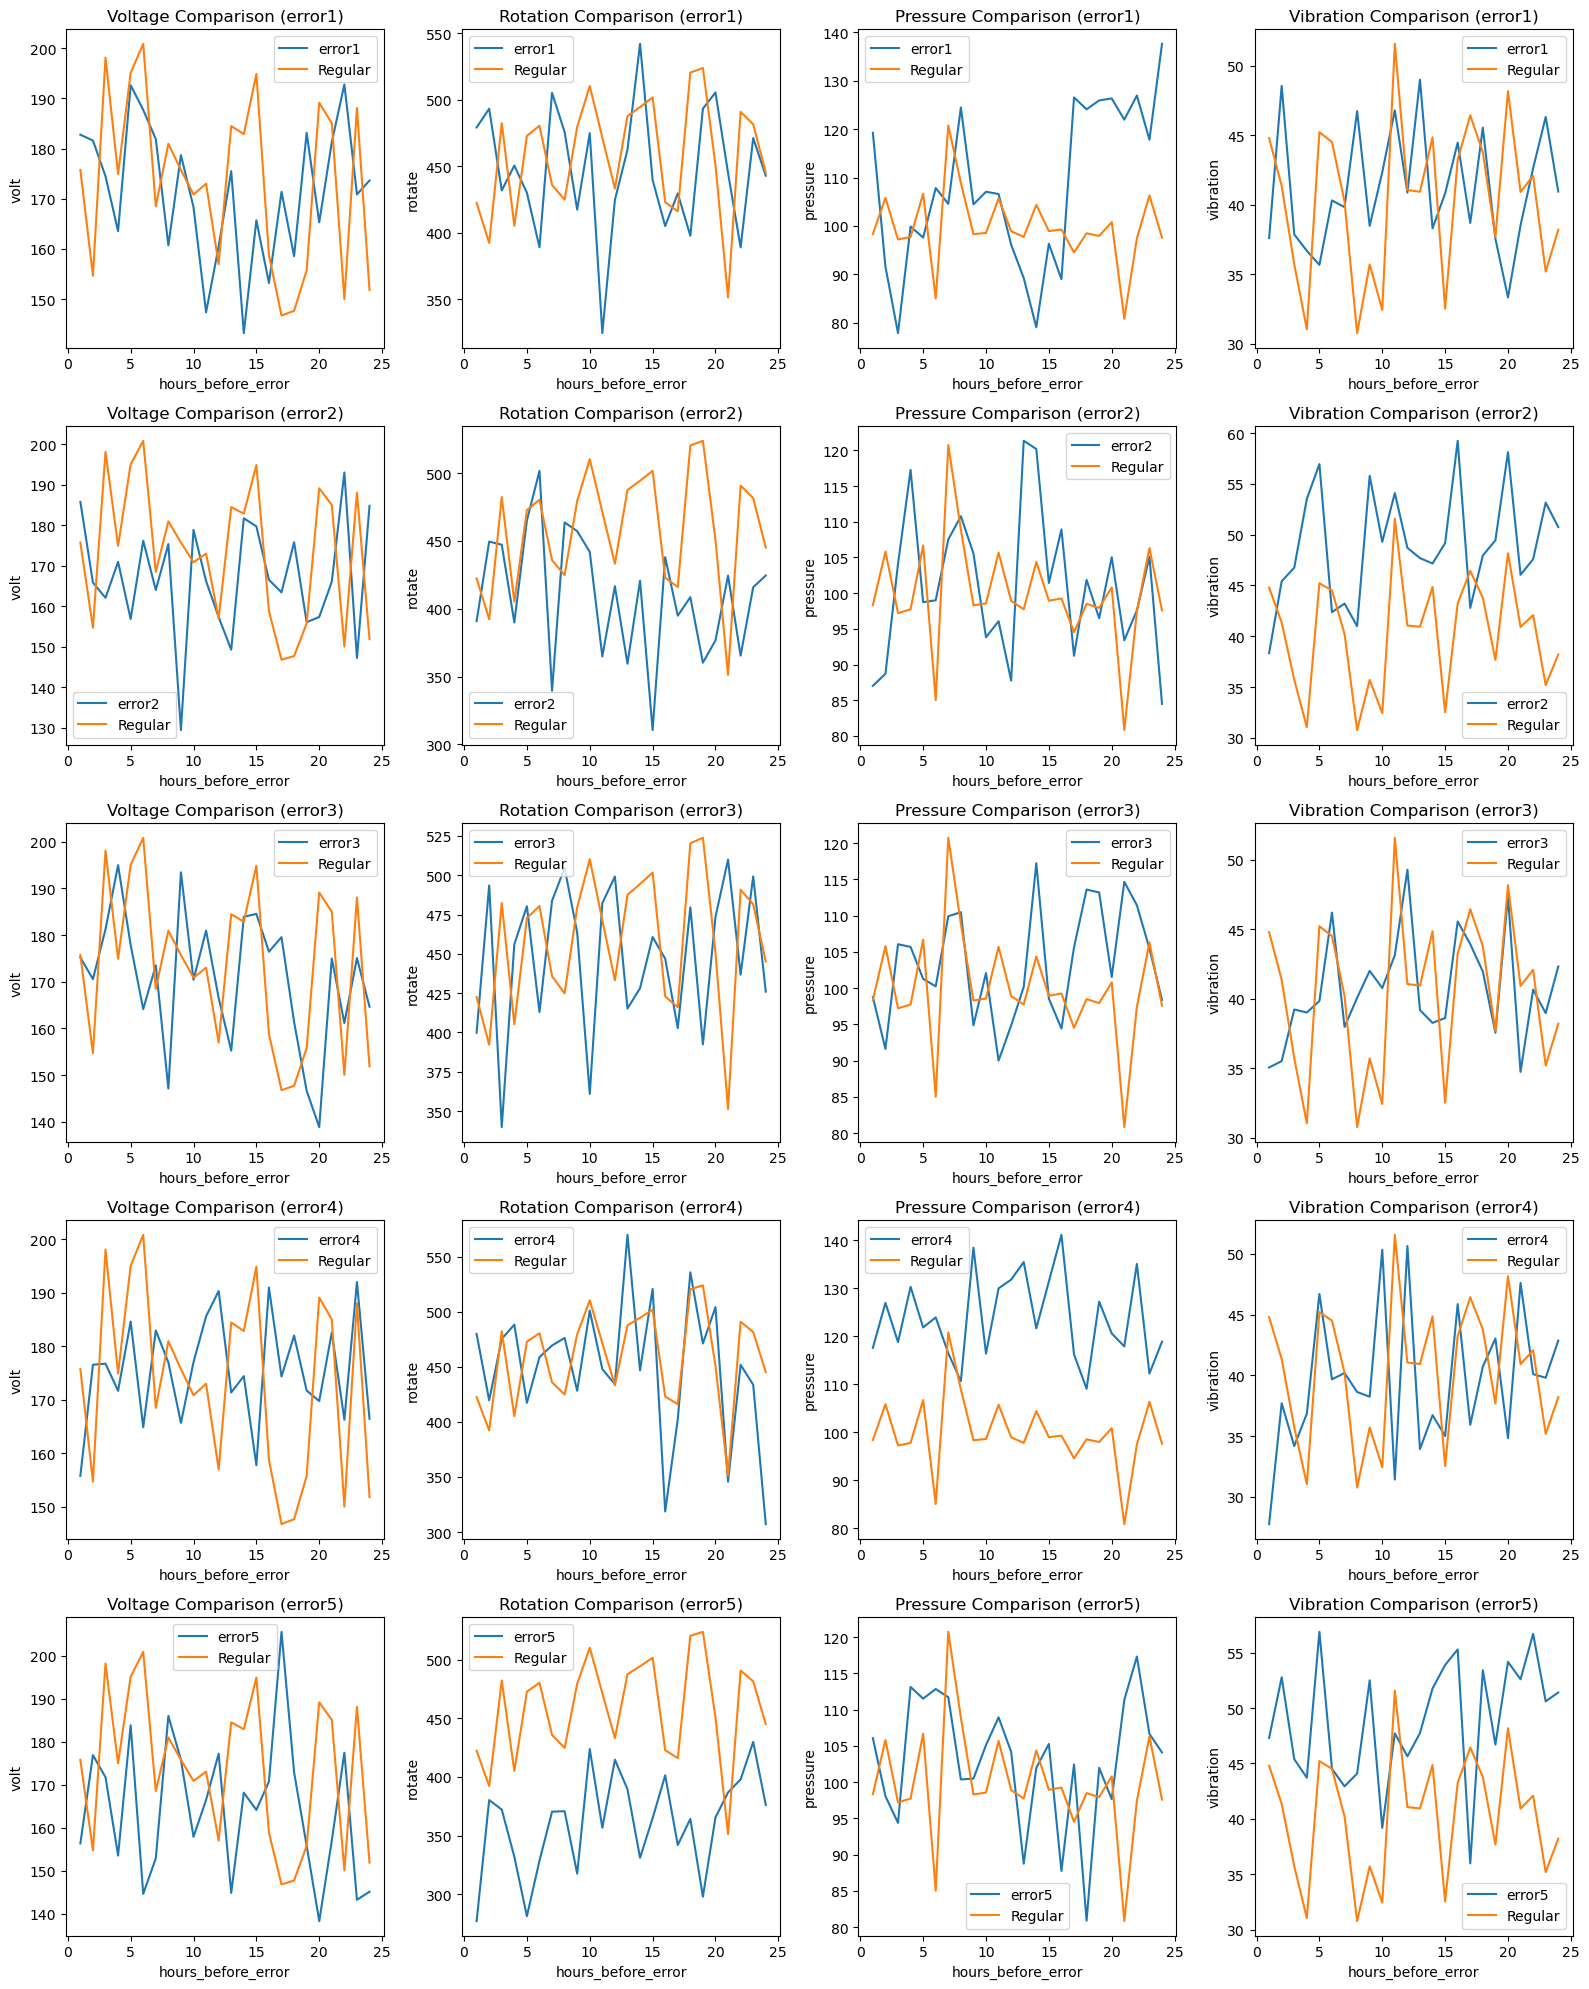

In [30]:
# Filter for Machine 37 // same machine
machine_id = 37
etd = error_telemetry_df[error_telemetry_df["machineID"] == machine_id]

# Get unique error occurrences for Machine 1
error_ids = ["error1", "error2", "error3", "error4", "error5"]
error_plot_data_list = []  # Store error data for plotting

for i, error_id in enumerate(error_ids):
    # Extract error time for this specific error ID
    sample_error_time = etd[etd['errorID'] == error_id]["error_time"].iloc[0]

    # Extract telemetry data for the error occurrence
    error_plot_data = etd[etd["error_time"] == sample_error_time].copy()
    error_plot_data["hours_before_error"] = (error_plot_data["error_time"] - error_plot_data["datetime"]).dt.total_seconds() / 3600
    error_plot_data["Condition"] = error_id  # Assign error label
    error_plot_data_list.append(error_plot_data)

# Extract baseline data (Regular operation)
baseline_times = baseline_telemetry_df[baseline_telemetry_df["machineID"] == machine_id]["error_time"].unique()
sample_baseline_time = baseline_times[0] if len(baseline_times) > 0 else None

if sample_baseline_time:
    baseline_plot_data = baseline_telemetry_df[
        (baseline_telemetry_df["machineID"] == machine_id) & 
        (baseline_telemetry_df["error_time"] == sample_baseline_time)
    ].copy()

    baseline_plot_data["hours_before_error"] = (baseline_plot_data["error_time"] - baseline_plot_data["datetime"]).dt.total_seconds() / 3600
    baseline_plot_data["Condition"] = "Regular"

# Create separate plots for each error
fig, axes = plt.subplots(len(error_plot_data_list), 4, figsize=(16, len(error_plot_data_list) * 4))

for i, error_plot_data in enumerate(error_plot_data_list):
    condition_label = error_plot_data["Condition"].iloc[0]  # Get error label

    # Voltage Plot
    sns.lineplot(data=error_plot_data, x="hours_before_error", y="volt", label=condition_label, ax=axes[i, 0])
    sns.lineplot(data=baseline_plot_data, x="hours_before_error", y="volt", label="Regular", ax=axes[i, 0])
    axes[i, 0].set_title(f"Voltage Comparison ({condition_label})")
    
    # Rotation Plot
    sns.lineplot(data=error_plot_data, x="hours_before_error", y="rotate", label=condition_label, ax=axes[i, 1])
    sns.lineplot(data=baseline_plot_data, x="hours_before_error", y="rotate", label="Regular", ax=axes[i, 1])
    axes[i, 1].set_title(f"Rotation Comparison ({condition_label})")

    # Pressure Plot
    sns.lineplot(data=error_plot_data, x="hours_before_error", y="pressure", label=condition_label, ax=axes[i, 2])
    sns.lineplot(data=baseline_plot_data, x="hours_before_error", y="pressure", label="Regular", ax=axes[i, 2])
    axes[i, 2].set_title(f"Pressure Comparison ({condition_label})")

    # Vibration Plot
    sns.lineplot(data=error_plot_data, x="hours_before_error", y="vibration", label=condition_label, ax=axes[i, 3])
    sns.lineplot(data=baseline_plot_data, x="hours_before_error", y="vibration", label="Regular", ax=axes[i, 3])
    axes[i, 3].set_title(f"Vibration Comparison ({condition_label})")


# Adjust layout for clarity
plt.tight_layout()
plt.show()


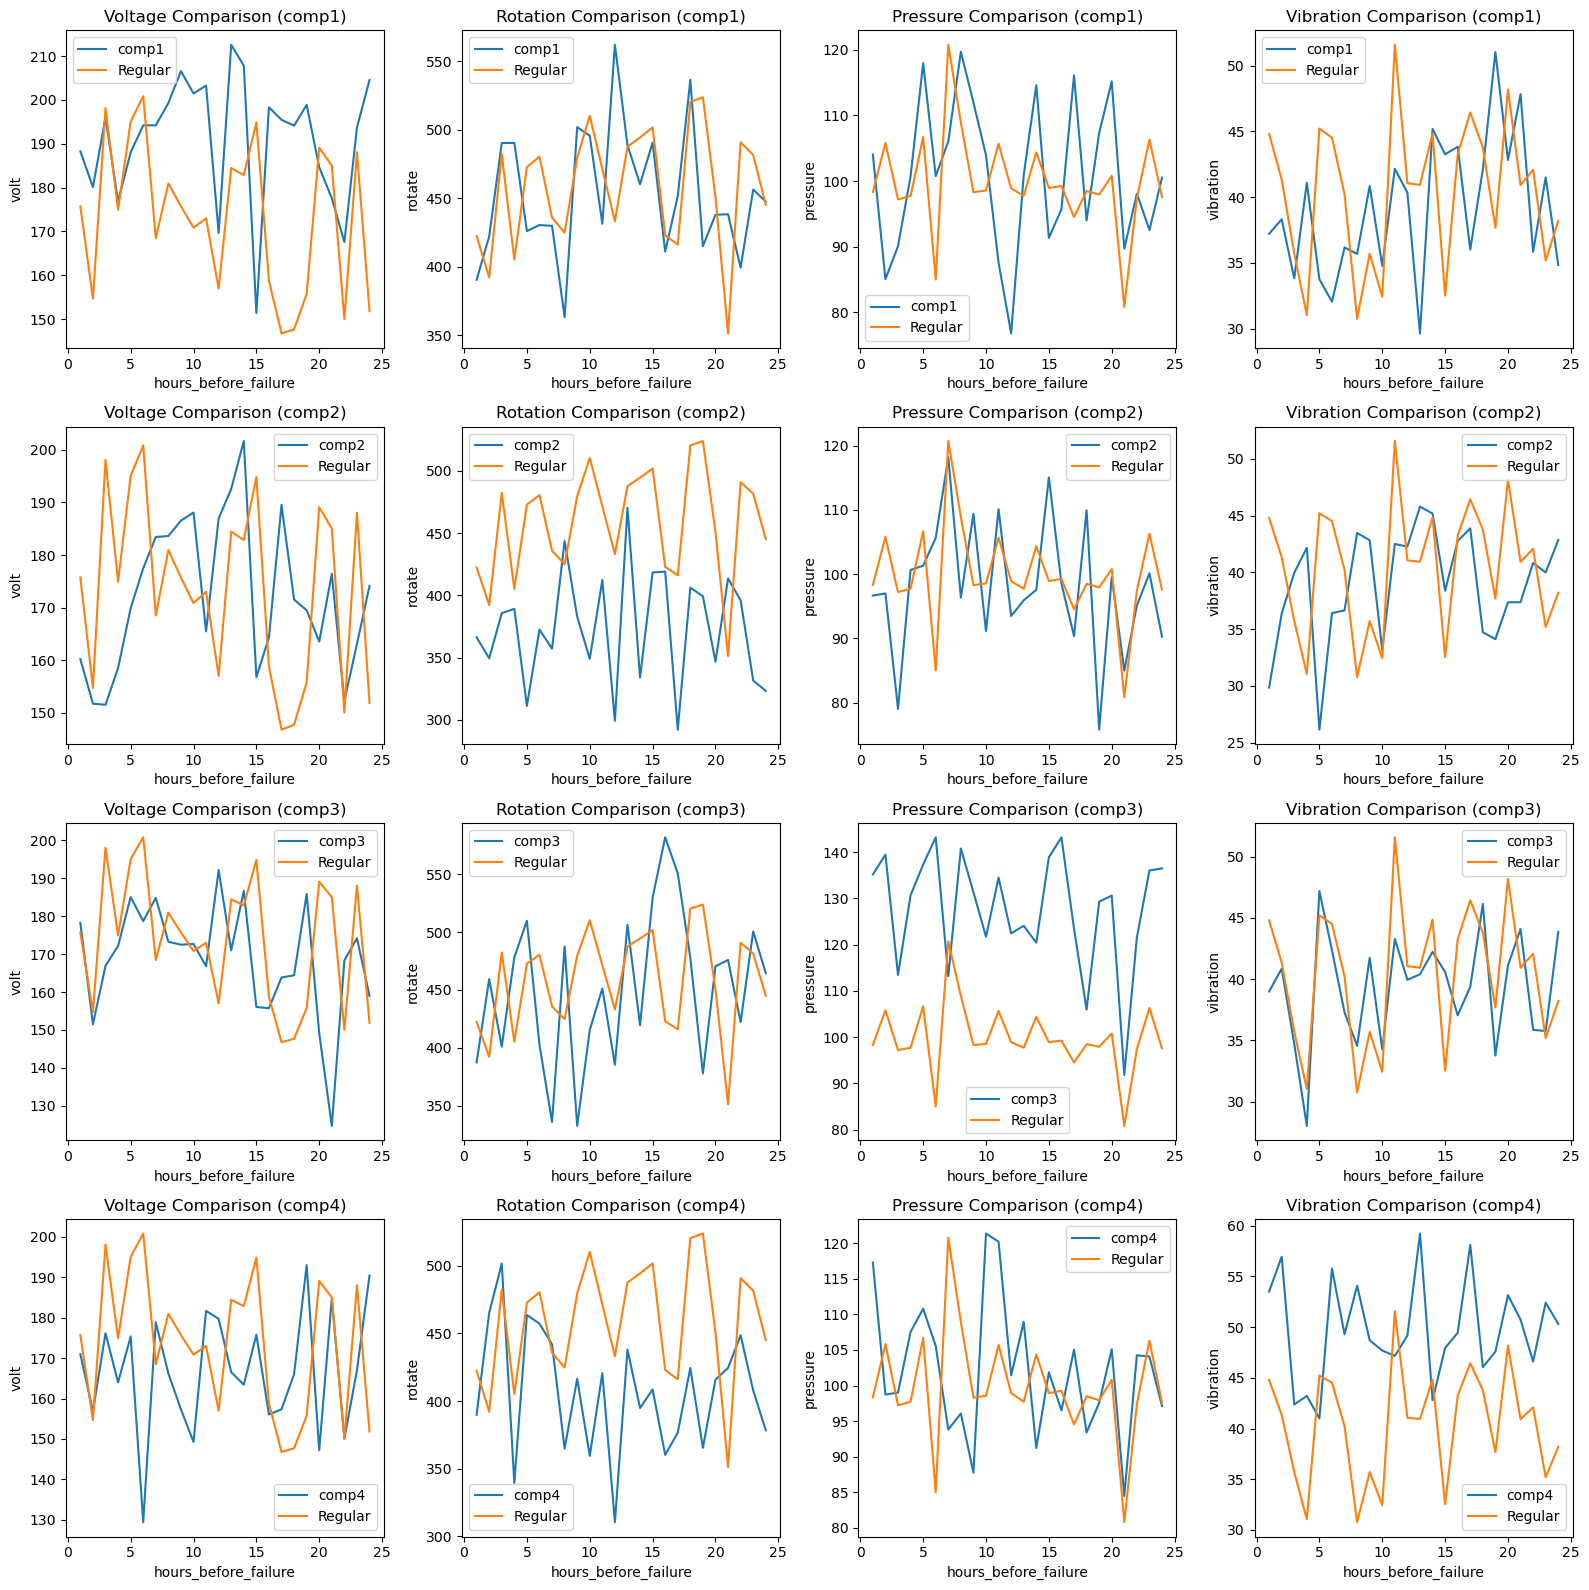

In [31]:
# Filter for Machine 37 // same machine
machine_id = 37
ftd = failure_telemetry_df[failure_telemetry_df["machineID"] == machine_id]

# Get unique failure occurrences for Machine 1
failure_ids = ['comp1', 'comp2', 'comp3', 'comp4']
failure_plot_data_list = []  # Store failure data for plotting

for i, failure_id in enumerate(failure_ids):
    # Extract failure time for this specific failure ID
    sample_failure_time = ftd[ftd['failure'] == failure_id]["failure_time"].iloc[0]

    # Extract telemetry data for the failure occurrence
    failure_plot_data = ftd[ftd["failure_time"] == sample_failure_time].copy()
    failure_plot_data["hours_before_failure"] = (failure_plot_data["failure_time"] - failure_plot_data["datetime"]).dt.total_seconds() / 3600
    failure_plot_data["Condition"] = failure_id  # Assign failure label
    failure_plot_data_list.append(failure_plot_data)

# Extract baseline data (Regular operation)
baseline_times = baseline_telemetry_df[baseline_telemetry_df["machineID"] == machine_id]["failure_time"].unique()
sample_baseline_time = baseline_times[0] if len(baseline_times) > 0 else None

if sample_baseline_time:
    baseline_plot_data = baseline_telemetry_df[
        (baseline_telemetry_df["machineID"] == machine_id) & 
        (baseline_telemetry_df["failure_time"] == sample_baseline_time)
    ].copy()

    baseline_plot_data["hours_before_failure"] = (baseline_plot_data["failure_time"] - baseline_plot_data["datetime"]).dt.total_seconds() / 3600
    baseline_plot_data["Condition"] = "Regular"

# Create separate plots for each failure
fig, axes = plt.subplots(len(failure_plot_data_list), 4, figsize=(16, len(failure_plot_data_list) * 4))

for i, failure_plot_data in enumerate(failure_plot_data_list):
    condition_label = failure_plot_data["Condition"].iloc[0]  # Get failure label

    # Voltage Plot
    sns.lineplot(data=failure_plot_data, x="hours_before_failure", y="volt", label=condition_label, ax=axes[i, 0])
    sns.lineplot(data=baseline_plot_data, x="hours_before_failure", y="volt", label="Regular", ax=axes[i, 0])
    axes[i, 0].set_title(f"Voltage Comparison ({condition_label})")
    
    # Rotation Plot
    sns.lineplot(data=failure_plot_data, x="hours_before_failure", y="rotate", label=condition_label, ax=axes[i, 1])
    sns.lineplot(data=baseline_plot_data, x="hours_before_failure", y="rotate", label="Regular", ax=axes[i, 1])
    axes[i, 1].set_title(f"Rotation Comparison ({condition_label})")

    # Pressure Plot
    sns.lineplot(data=failure_plot_data, x="hours_before_failure", y="pressure", label=condition_label, ax=axes[i, 2])
    sns.lineplot(data=baseline_plot_data, x="hours_before_failure", y="pressure", label="Regular", ax=axes[i, 2])
    axes[i, 2].set_title(f"Pressure Comparison ({condition_label})")

    # Vibration Plot
    sns.lineplot(data=failure_plot_data, x="hours_before_failure", y="vibration", label=condition_label, ax=axes[i, 3])
    sns.lineplot(data=baseline_plot_data, x="hours_before_failure", y="vibration", label="Regular", ax=axes[i, 3])
    axes[i, 3].set_title(f"Vibration Comparison ({condition_label})")


# Adjust layout for clarity
plt.tight_layout()
plt.show()

### Feature Engineering and Modelling

In [33]:
compiled_df.info() # Since failure / error are rare, there exists a class imbalance 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877878 entries, 0 to 877877
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   datetime   877878 non-null  datetime64[ns]
 1   machineID  877878 non-null  int64         
 2   volt       877878 non-null  float64       
 3   rotate     877878 non-null  float64       
 4   pressure   877878 non-null  float64       
 5   vibration  877878 non-null  float64       
 6   model      877878 non-null  object        
 7   age        877878 non-null  int64         
 8   failure    761 non-null     object        
 9   errorID    3919 non-null    object        
 10  comp       2886 non-null    object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(4)
memory usage: 73.7+ MB


In [136]:
data = compiled_df.copy()

Model 1: To forecast telemetry data 24 hours in advance

In [137]:
# Lag features
for col in ["volt", "rotate", "pressure", "vibration"]:
    for lag in [1, 3, 6, 12, 24]:
        data[f"{col}_lag_{lag}"] = data.groupby("machineID")[col].shift(lag)

# Rolling statistics
for col in ["volt", "rotate", "pressure", "vibration"]:
    for window in [6, 12, 24]:
        data[f"{col}_rolling_mean_{window}"] = data.groupby("machineID")[col].rolling(window=window, min_periods=1).mean().reset_index(0, drop=True)
        data[f"{col}_rolling_std_{window}"] = data.groupby("machineID")[col].rolling(window=window, min_periods=1).std().reset_index(0, drop=True)
    data[f"{col}_ewm_12"] = data.groupby("machineID")[col].transform(lambda x: x.ewm(span=12).mean())
    data[f"{col}_ewm_24"] = data.groupby("machineID")[col].transform(lambda x: x.ewm(span=24).mean())
    data[f"{col}_cumsum"] = data.groupby("machineID")[col].cumsum()


# Datetime features
data["hour"] = data["datetime"].dt.hour
data["day_of_week"] = data["datetime"].dt.dayofweek
data["month"] = data["datetime"].dt.month

In [138]:
data.shape

(877878, 70)

In [139]:
data.describe()

,datetime,machineID,volt,rotate,pressure,vibration,age,volt_lag_1,volt_lag_3,volt_lag_6,...,vibration_rolling_mean_12,vibration_rolling_std_12,vibration_rolling_mean_24,vibration_rolling_std_24,vibration_ewm_12,vibration_ewm_24,vibration_cumsum,hour,day_of_week,month
count,877878,877878.000000,877878.000000,877878.000000,877878.000000,877878.000000,877878.000000,877778.000000,877578.000000,877278.000000,...,877878.000000,877778.000000,877878.000000,877778.000000,877878.000000,877878.000000,877878.000000,877878.000000,877878.000000,877878.000000
mean,2015-07-02 17:59:32.200692480,50.500001,170.784239,446.552883,100.864709,40.388412,11.331142,170.783805,170.783270,170.782574,...,40.388092,4.916027,40.388006,5.001459,40.388170,40.388150,177301.287439,11.488222,3.000683,6.525418
min,2015-01-01 06:00:00,1.000000,97.333604,138.432075,51.237106,14.877054,0.000000,97.333604,97.333604,97.333604,...,22.973289,0.000000,22.973289,0.000000,22.973289,22.973289,22.973289,0.000000,0.000000,1.000000
25%,2015-04-02 12:00:00,25.000000,160.308166,412.245488,93.500230,36.778872,7.000000,160.307841,160.307193,160.307005,...,39.078840,4.162083,39.353993,4.459485,39.087087,39.366342,88589.705727,6.000000,1.000000,4.000000
50%,2015-07-02 18:00:00,50.000000,170.611766,447.524832,100.428426,40.239811,12.000000,170.611308,170.610915,170.610212,...,40.089389,4.868078,40.072409,4.958405,40.095682,40.087627,177308.097454,11.000000,3.000000,7.000000
75%,2015-10-02 00:00:00,76.000000,181.012842,482.148314,107.560029,43.788410,16.000000,181.012305,181.011256,181.009691,...,41.145831,5.613912,40.835939,5.484912,41.153523,40.854058,266008.267096,17.000000,5.000000,10.000000
max,2016-01-01 06:00:00,100.000000,255.124717,695.020984,185.951998,76.791072,20.000000,255.124717,255.124717,255.124717,...,63.568548,13.712220,61.932124,13.203534,63.916218,61.474810,357676.858302,23.000000,6.000000,12.000000
std,NaN,28.867029,15.513778,52.712569,11.055610,5.373539,5.827578,15.513558,15.513327,15.512751,...,2.377887,1.083911,2.073608,0.803130,2.345247,2.001151,102382.488446,6.919463,1.997337,3.448081


In [140]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877878 entries, 0 to 877877
Data columns (total 70 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   datetime                   877878 non-null  datetime64[ns]
 1   machineID                  877878 non-null  int64         
 2   volt                       877878 non-null  float64       
 3   rotate                     877878 non-null  float64       
 4   pressure                   877878 non-null  float64       
 5   vibration                  877878 non-null  float64       
 6   model                      877878 non-null  object        
 7   age                        877878 non-null  int64         
 8   failure                    761 non-null     object        
 9   errorID                    3919 non-null    object        
 10  comp                       2886 non-null    object        
 11  volt_lag_1                 877778 non-null  float64 

In [142]:
# Target variable (24-hour ahead telemetry)
telemetry_cols = ["volt", "rotate", "pressure", "vibration"]

# Create future target variables (24-hour ahead values)
for sensor in telemetry_cols:
    data[f"{sensor}_future"] = data.groupby("machineID")[sensor].shift(-24)

# Fill NaNs in lags and rolling features with forward-fill
lag_cols = [col for col in data.columns if "_lag_" in col or "_rolling_" in col]
data[lag_cols] = data[lag_cols].groupby(data["machineID"]).ffill()

# Fill any remaining NaNs with column median
data[lag_cols] = data[lag_cols].fillna(data[lag_cols].median())

# Drop NaN rows caused by shifting
target_cols = [f"{sensor}_future" for sensor in telemetry_cols]
data.dropna(subset=target_cols, inplace=True)

# Select features and split data
feature_cols = [col for col in data.columns if "_lag_" in col or "_rolling_" in col]
feature_cols.extend([f"{col}_ewm_12" for col in ["volt", "rotate", "pressure", "vibration"]])
feature_cols.extend([f"{col}_ewm_24" for col in ["volt", "rotate", "pressure", "vibration"]])
feature_cols.extend([f"{col}_cumsum" for col in ["volt", "rotate", "pressure", "vibration"]])

X = data[feature_cols]
print("Selected Features:", feature_cols)
X = data[feature_cols]
y = data[target_cols]

print(f"Final shapes: X = {X.shape}, y = {y.shape}")  # Should be equal in rows

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f"Train shape: {X_train.shape} and {y_train.shape}, Test shape: {X_test.shape} and {y_test.shape}")  # Ensure both sets exist

# Train XGBoost model for each sensor
models = {}
for target in target_cols:
    model = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.05, tree_method="hist", random_state=42)
    model.fit(X_train, y_train[target])
    models[target] = model

Selected Features: ['volt_lag_1', 'volt_lag_3', 'volt_lag_6', 'volt_lag_12', 'volt_lag_24', 'rotate_lag_1', 'rotate_lag_3', 'rotate_lag_6', 'rotate_lag_12', 'rotate_lag_24', 'pressure_lag_1', 'pressure_lag_3', 'pressure_lag_6', 'pressure_lag_12', 'pressure_lag_24', 'vibration_lag_1', 'vibration_lag_3', 'vibration_lag_6', 'vibration_lag_12', 'vibration_lag_24', 'volt_rolling_mean_6', 'volt_rolling_std_6', 'volt_rolling_mean_12', 'volt_rolling_std_12', 'volt_rolling_mean_24', 'volt_rolling_std_24', 'rotate_rolling_mean_6', 'rotate_rolling_std_6', 'rotate_rolling_mean_12', 'rotate_rolling_std_12', 'rotate_rolling_mean_24', 'rotate_rolling_std_24', 'pressure_rolling_mean_6', 'pressure_rolling_std_6', 'pressure_rolling_mean_12', 'pressure_rolling_std_12', 'pressure_rolling_mean_24', 'pressure_rolling_std_24', 'vibration_rolling_mean_6', 'vibration_rolling_std_6', 'vibration_rolling_mean_12', 'vibration_rolling_std_12', 'vibration_rolling_mean_24', 'vibration_rolling_std_24', 'volt_ewm_12', 

In [143]:
# Dictionary to store evaluation results
evaluation_results = {}

# Evaluate each model for the 4 telemetry sensors
for target in ["volt_future", "rotate_future", "pressure_future", "vibration_future"]:
    y_pred = models[target].predict(X_test)  # Get predictions
    
    # Compute metrics
    mae = mean_absolute_error(y_test[target], y_pred)
    mse = mean_squared_error(y_test[target], y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test[target], y_pred)
    
    # Store results
    evaluation_results[target] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R² Score": r2}

# Convert to DataFrame for better visualization
eval_df = pd.DataFrame(evaluation_results).T

In [144]:
eval_df

,MAE,MSE,RMSE,R² Score
volt_future,12.249896,237.081217,15.397442,0.018603
rotate_future,41.251631,2704.375003,52.003606,0.032761
pressure_future,8.378396,114.125694,10.682963,0.079648
vibration_future,4.138213,27.354420,5.230145,0.050164


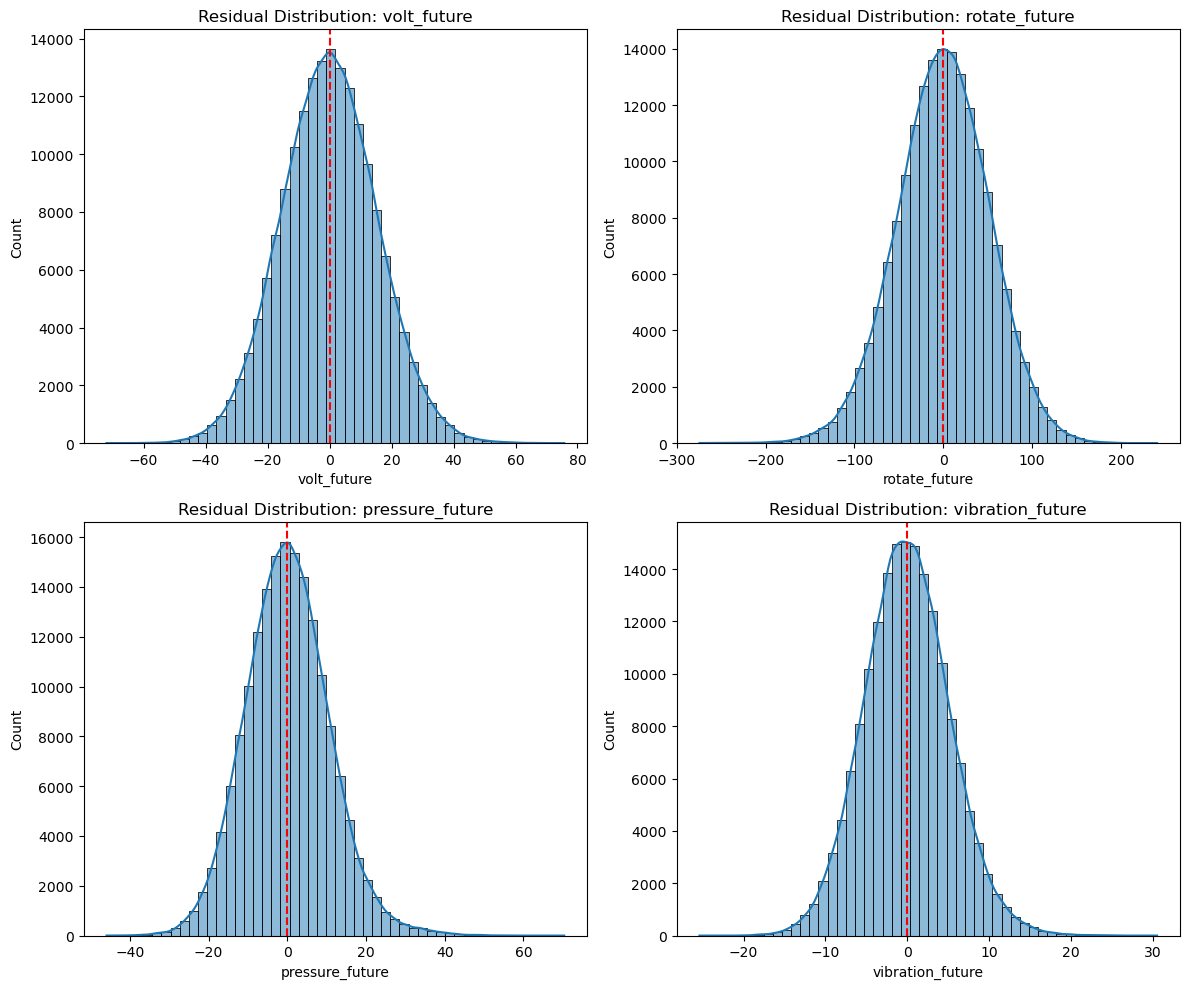

In [145]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, target in enumerate(["volt_future", "rotate_future", "pressure_future", "vibration_future"]):
    ax = axes[i // 2, i % 2]
    residuals = y_test[target] - models[target].predict(X_test)
    
    sns.histplot(residuals, bins=50, kde=True, ax=ax)
    ax.axvline(0, color="red", linestyle="dashed")  # Ideal zero line
    ax.set_title(f"Residual Distribution: {target}")

plt.tight_layout()
plt.show()


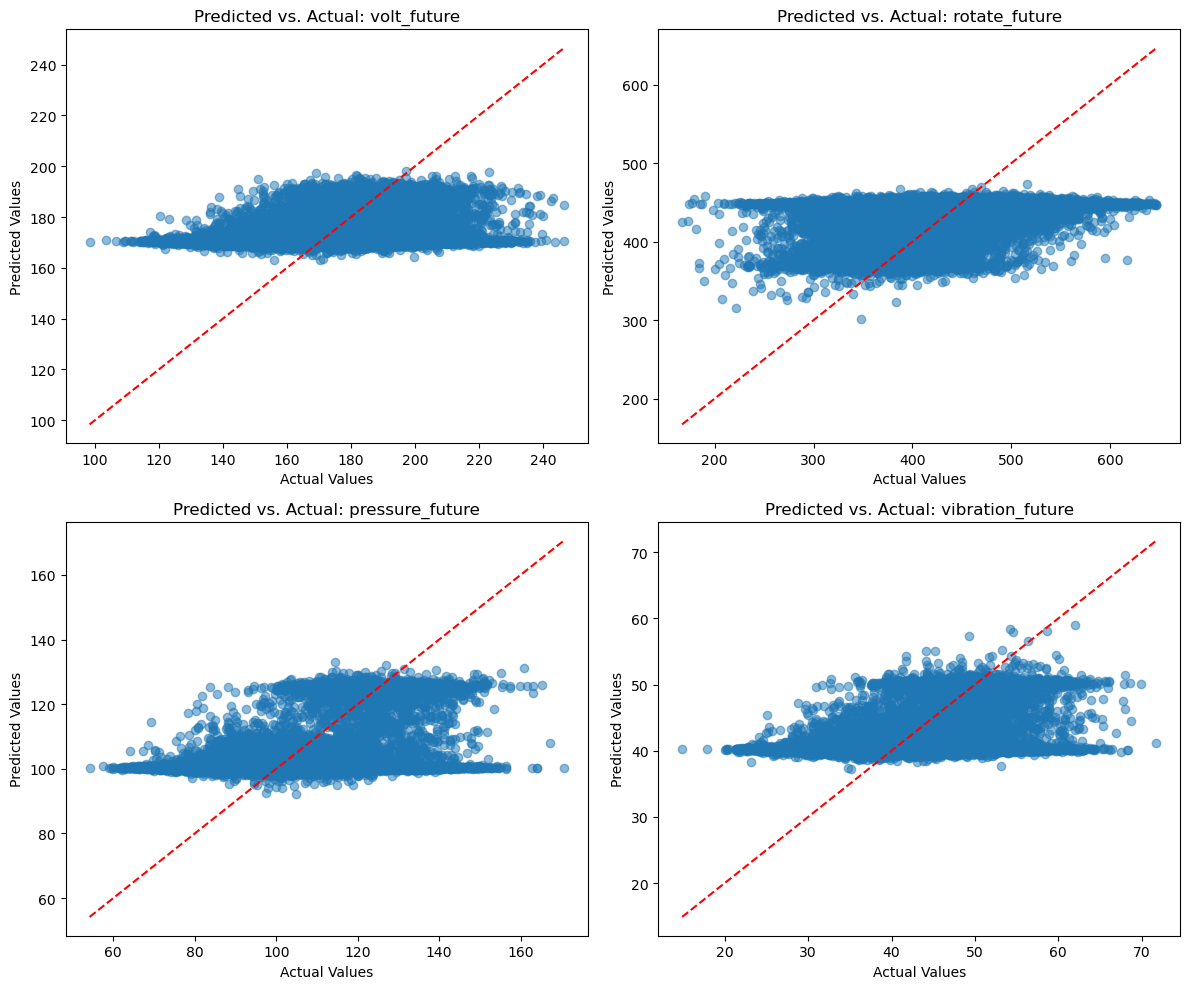

In [146]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, target in enumerate(["volt_future", "rotate_future", "pressure_future", "vibration_future"]):
    ax = axes[i // 2, i % 2]
    y_pred = models[target].predict(X_test)
    
    ax.scatter(y_test[target], y_pred, alpha=0.5)
    ax.plot([y_test[target].min(), y_test[target].max()], 
            [y_test[target].min(), y_test[target].max()], '--', color='red')  # Ideal line
    ax.set_xlabel("Actual Values")
    ax.set_ylabel("Predicted Values")
    ax.set_title(f"Predicted vs. Actual: {target}")

plt.tight_layout()
plt.show()

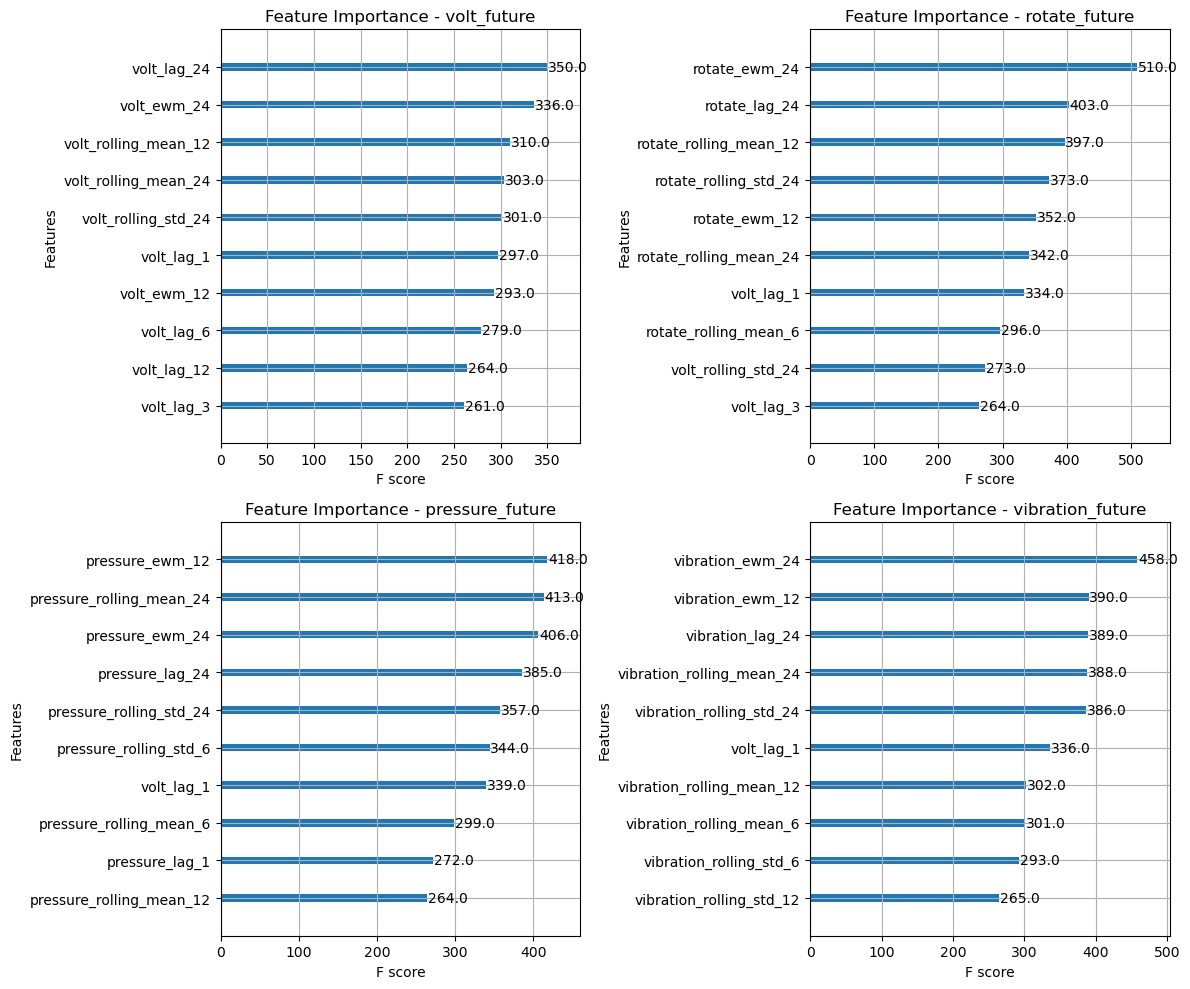

In [147]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, target in enumerate(["volt_future", "rotate_future", "pressure_future", "vibration_future"]):
    ax = axes[i // 2, i % 2]
    plot_importance(models[target], ax=ax, max_num_features=10)
    ax.set_title(f"Feature Importance - {target}")

plt.tight_layout()
plt.show()


In [148]:
for lag in [1, 3, 6, 12, 24]:
    print(f"Lag {lag} Autocorrelation:")
    for target in ["volt", "rotate", "pressure", "vibration"]:
        print(f"  {target}: {data[target].autocorr(lag=lag):.4f}")

Lag 1 Autocorrelation:
  volt: 0.0655
  rotate: 0.0967
  pressure: 0.1779
  vibration: 0.1319
Lag 3 Autocorrelation:
  volt: 0.0613
  rotate: 0.0915
  pressure: 0.1679
  vibration: 0.1256
Lag 6 Autocorrelation:
  volt: 0.0572
  rotate: 0.0863
  pressure: 0.1583
  vibration: 0.1166
Lag 12 Autocorrelation:
  volt: 0.0478
  rotate: 0.0752
  pressure: 0.1341
  vibration: 0.1007
Lag 24 Autocorrelation:
  volt: 0.0329
  rotate: 0.0494
  pressure: 0.0915
  vibration: 0.0675


In [ ]:
forecast_horizon = 24  # 24-hour forecast

# Create shifted forecast telemetry values - we are going back in time 
for col in ["volt", "rotate", "pressure", "vibration"]:
    data[f"{col}_future"] = data.groupby("machineID")[col].shift(-forecast_horizon)

# Forecast whether an error will occur (classification problem)
data["error_future"] = data.groupby("machineID")["errorID"].shift(-forecast_horizon).fillna("No Error")

In [ ]:
# create lagged variables to capture trends / bhevaiour before failure
lag_hours = [1, 3, 6, 12, 24]

for col in ["volt", "rotate", "pressure", "vibration"]:
    for lag in lag_hours:
        data[f"{col}_lag_{lag}"] = data.groupby("machineID")[col].shift(lag)

In [ ]:
window_sizes = [6, 12, 24]  # Short-term and long-term trends

for col in ["volt", "rotate", "pressure", "vibration"]:
    for window in window_sizes:
        data[f"{col}_rolling_mean_{window}"] = (
            data.groupby("machineID")[col]
            .rolling(window, min_periods=1)
            .mean()
            .reset_index(0, drop=True)
        )
        data[f"{col}_rolling_std_{window}"] = (
            data.groupby("machineID")[col]
            .rolling(window, min_periods=1)
            .std()
            .reset_index(0, drop=True)
        )

In [ ]:
data["hour"] = data["datetime"].dt.hour
data["day_of_week"] = data["datetime"].dt.dayofweek
data["month"] = data["datetime"].dt.month
data["is_weekend"] = (data["day_of_week"] >= 5).astype(int)

In [ ]:
data.head(2)

,datetime,machineID,volt,rotate,pressure,vibration,age,failure,errorID,comp,...,vibration_rolling_mean_6,vibration_rolling_std_6,vibration_rolling_mean_12,vibration_rolling_std_12,vibration_rolling_mean_24,vibration_rolling_std_24,hour,day_of_week,month,is_weekend
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,18,NaN,NaN,NaN,...,45.087686,NaN,45.087686,NaN,45.087686,NaN,6,3,1,0
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,18,NaN,NaN,NaN,...,44.250829,1.183494,44.250829,1.183494,44.250829,1.183494,7,3,1,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877878 entries, 0 to 877877
Data columns (total 70 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   datetime                   877878 non-null  datetime64[ns]
 1   machineID                  877878 non-null  int64         
 2   volt                       877878 non-null  float64       
 3   rotate                     877878 non-null  float64       
 4   pressure                   877878 non-null  float64       
 5   vibration                  877878 non-null  float64       
 6   age                        877878 non-null  int64         
 7   failure                    761 non-null     object        
 8   errorID                    3919 non-null    object        
 9   comp                       2886 non-null    object        
 10  model_model1               877878 non-null  bool          
 11  model_model2               877878 non-null  bool    

In [ ]:
data.head()

,datetime,machineID,volt,rotate,pressure,vibration,age,failure,errorID,comp,...,vibration_rolling_mean_6,vibration_rolling_std_6,vibration_rolling_mean_12,vibration_rolling_std_12,vibration_rolling_mean_24,vibration_rolling_std_24,hour,day_of_week,month,is_weekend
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,18,NaN,NaN,NaN,...,45.087686,NaN,45.087686,NaN,45.087686,NaN,6,3,1,0
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,18,NaN,NaN,NaN,...,44.250829,1.183494,44.250829,1.183494,44.250829,1.183494,7,3,1,0
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,18,NaN,NaN,NaN,...,40.893502,5.874970,40.893502,5.874970,40.893502,5.874970,8,3,1,0
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,18,NaN,NaN,NaN,...,40.950662,4.798255,40.950662,4.798255,40.950662,4.798255,9,3,1,0
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,18,NaN,NaN,NaN,...,37.958632,7.875828,37.958632,7.875828,37.958632,7.875828,10,3,1,0


In [ ]:
# Ensure datetime format
data["datetime"] = pd.to_datetime(data["datetime"])

# Extract maintenance events
maint_events = data[["datetime", "machineID", "comp"]].dropna().copy()

# Forward-fill last maintenance timestamp within each machineID group
maint_events["last_maint_time"] = maint_events.groupby("machineID")["datetime"].transform("ffill")

# Merge back into the main dataset
data = data.merge(maint_events[["datetime", "machineID", "last_maint_time"]], on=["datetime", "machineID"], how="left")

# Forward-fill the last maintenance event for each machine
data["last_maint_time"] = data.groupby("machineID")["last_maint_time"].ffill()

# Compute time since last maintenance in hours
data["time_since_last_maint"] = (data["datetime"] - data["last_maint_time"]).dt.total_seconds() / 3600

# Fill NaNs (machines with no maintenance history)
data["time_since_last_maint"].fillna(9999, inplace=True)

# Drop temporary column
data.drop(columns=["last_maint_time"], inplace=True)


/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_51139/2457580055.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["time_since_last_maint"].fillna(9999, inplace=True)


In [ ]:
# Extract errorenance events
error_events = data[["datetime", "machineID", "errorID"]].dropna().copy()

# Forward-fill last errorenance timestamp within each machineID group
error_events["last_error_time"] = error_events.groupby("machineID")["datetime"].transform("ffill")

# Merge back into the main dataset
data = data.merge(error_events[["datetime", "machineID", "last_error_time"]], on=["datetime", "machineID"], how="left")

# Forward-fill the last errorenance event for each machine
data["last_error_time"] = data.groupby("machineID")["last_error_time"].ffill()

# Compute time since last errorenance in hours
data["time_since_last_error"] = (data["datetime"] - data["last_error_time"]).dt.total_seconds() / 3600

# Fill NaNs (machines with no errorenance history)
data["time_since_last_error"].fillna(9999, inplace=True)

# Drop temporary column
data.drop(columns=["last_error_time"], inplace=True)

/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_51139/3964952788.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["time_since_last_error"].fillna(9999, inplace=True)


In [ ]:
data.drop(columns=["datetime", "failure"], inplace=True)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
# !conda install xgboost

In [ ]:
data['error_future']

0         No Error
1         No Error
2         No Error
3         No Error
4         No Error
            ...   
880371    No Error
880372    No Error
880373    No Error
880374    No Error
880375    No Error
Name: error_future, Length: 880376, dtype: object

In [ ]:
from xgboost import XGBRegressor

features = data.drop(columns=["volt_future", "rotate_future", "pressure_future", "vibration_future", "error_future", "errorID", "comp", "failure_label"])
target = data["volt_future"]

model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(features, target)

XGBoostError: [02:04:30] /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/data/data.cc:461: Check failed: valid: Label contains NaN, infinity or a value too large.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001498b59b4 dmlc::LogMessageFatal::~LogMessageFatal() + 116
  [bt] (1) 2   libxgboost.dylib                    0x0000000149952f69 xgboost::MetaInfo::SetInfoFromHost(xgboost::GenericParameter const&, xgboost::StringView, xgboost::Json) + 4601
  [bt] (2) 3   libxgboost.dylib                    0x0000000149951c3f xgboost::MetaInfo::SetInfo(xgboost::GenericParameter const&, xgboost::StringView, xgboost::StringView) + 159
  [bt] (3) 4   libxgboost.dylib                    0x00000001498ccc19 XGDMatrixSetInfoFromInterface + 249
  [bt] (4) 5   libffi.8.dylib                      0x000000010bc88972 ffi_call_unix64 + 82
  [bt] (5) 6   ???                                 0x0000000305cb95b0 0x0 + 12982130096



In [ ]:
from xgboost import XGBClassifier

target_error = le.fit_transform(data["error_future"])

model_error = XGBClassifier(n_estimators=100, random_state=42)
model_error.fit(features, target_error)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(features)
print(f"MAE: {mean_absolute_error(target, y_pred)}")
print(f"RMSE: {mean_squared_error(target, y_pred, squared=False)}")


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

y_pred_error = model_error.predict(features)
precision, recall, f1, _ = precision_recall_fscore_support(target_error, y_pred_error, average='macro')

print(f"Precision: {precision}, Recall: {recall}, F1-score: {f1}")


Precision: 0.9987070008928738, Recall: 0.5061368642853922, F1-score: 0.6214393150234517


In [ ]:
# failure_error_maint['dt'] = failure_error_maint['datetime'].apply(lambda x: pd.to_datetime(x))

In [ ]:
# Check 1: Are there cases where multiple components failed at the same date and time?
# Check 2: Is it valid to then merge all mainte

In [ ]:
# Potential ideas 

# Explore anomalies within each telemetry set (indepdent of failures, errors, etc)
# 

{'error1': 1010, 'error2': 988, 'error3': 838, 'error4': 727, 'error5': 356}